# Testing LRCT

## What to Test:
    - We want to test LRCT on the following:
        - Single linear split
        - "Checkerboard" classification
        - Single nonlinear split
        - Set of nonlinear splits
        - Iris dataset
        - Cancer dataset

## How to Test (if "real-world" problem):
    - Set of parameters
    - GridSearchCV over the parameter set
    - Test against CART as well

In [125]:
from LRCT import LRCTree
from sklearn.datasets import load_iris, load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

%matplotlib inline
sns.set_style('darkgrid')

## Single Linear Split

In this section, we will test how LRCT performs at identifying a single linear split across 2 and 3 variables, both with additional variables as noise and without.  In addition, we will test adding noise to the data and leaving it out

### Across 2 Variables, no Additional Variables, no Noise

In [129]:
#Generate the fake data
np.random.seed(5648)
two_var_x = np.random.random((1000, 2))
two_var_x[:, 0] = two_var_x[:, 0] * 14
two_var_x[:, 1] = two_var_x[:, 1] * 8

df = pd.DataFrame(two_var_x, columns = ['col_0', 'col_1'])
target = df.apply(lambda row : 1 if row.col_1 > -1*row.col_0 + 10 else 0, axis = 1)
display(df.head())
display(target.value_counts())

x_train, x_test, y_train, y_test = train_test_split(df, target, test_size = 0.4, random_state = 21)
display(y_test.value_counts())

,col_0,col_1
0,0.526561,4.588875
1,7.399726,6.490421
2,13.494321,4.578247
3,4.035185,7.820860
4,7.371973,5.895390


1    575
0    425
dtype: int64

1    234
0    166
dtype: int64

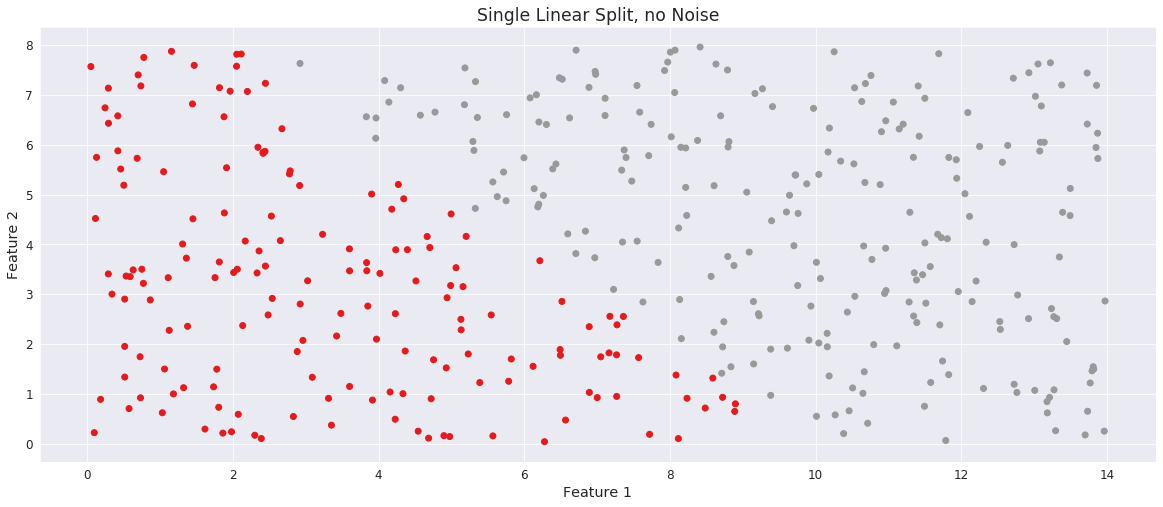

In [130]:
plt.figure(figsize = (20, 8))
plt.scatter(x_test.col_0, x_test.col_1, c = y_test, cmap = 'Set1')
plt.title('Single Linear Split, no Noise', fontsize = 'xx-large')
plt.xlabel('Feature 1', fontsize = 'x-large')
plt.ylabel('Feature 2', fontsize = 'x-large')
plt.xticks(fontsize = 'large')
plt.yticks(fontsize = 'large')
plt.show()

In [132]:
lrct = LRCTree(max_depth = 1).fit(x_train, y_train)
print('LRCT Decision Tree Structure:')
lrct.describe()
print('\n')
print(f'LRCT Accuracy Score: {lrct.score(x_test, y_test)}')

cart = DecisionTreeClassifier(max_depth = 1).fit(x_test, y_test)
print(f'CART Score: {cart.score(x_test, y_test)}')

LRCT Decision Tree Structure:
ID: 0, Parent ID: None, Depth: 0, Split: ('-0.8784715626859682*col_0 - col_1', -9.334081678707484)
-ID: 1, Parent ID: 0, Depth: 1, Split: nan
-ID: 2, Parent ID: 0, Depth: 1, Split: nan


LRCT Accuracy Score: 0.9775
CART Score: 0.8925


### Across 2 Variables, Additional Variables, no Noise

In [134]:
#Generate the fake data
np.random.seed(5648)
two_var_x = np.random.random((1000, 10))
two_var_x[:, 0] = two_var_x[:, 0] * 14
two_var_x[:, 1] = two_var_x[:, 1] * 8

df = pd.DataFrame(two_var_x, columns = [f'col_{i}' for i in range(10)])
target = df.apply(lambda row : 1 if row.col_1 > -1*row.col_0 + 10 else 0, axis = 1)
display(df.head())
display(target.value_counts())

x_train, x_test, y_train, y_test = train_test_split(df, target, test_size = 0.4, random_state = 21)
display(y_test.value_counts())

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9
0,0.526561,4.588875,0.528552,0.811303,0.963880,0.572281,0.288227,0.977607,0.526570,0.736924
1,5.637130,3.412889,0.989832,0.899133,0.498617,0.598368,0.704547,0.972985,0.275137,0.345230
2,0.714066,3.811455,0.694902,0.179677,0.943785,0.116094,0.895479,0.286599,0.171343,0.288328
3,13.720477,7.976714,0.763154,0.903692,0.830631,0.698605,0.352079,0.190098,0.697168,0.577805
4,7.769528,4.866656,0.703745,0.288501,0.440483,0.875562,0.765414,0.051112,0.067182,0.655207


1    577
0    423
dtype: int64

1    227
0    173
dtype: int64